In [1]:
# 加载数据集
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium   
0            1    14.23        1.71  2.43               15.6        127  \
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins   
0           2.80        3.06                  0.28             2.29  \
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05                          3.40     1050  
2             5.68  1.03                          3.17     1185  
3             7.80  0.86                          3.45     1480  
4             4.32  1.04                          2.93      735

In [2]:
# 切分数据集为训练集和测试集
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

In [3]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  #标准化
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
# 手动实现PCA
# 获取特征向量和特征值
import numpy as np
cov_mat = np.cov(X_train_std.T)  #计算标准化训练集的协方差矩阵
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)   #用np.linalg.eig完成特征分解

print('\nEigenvalues \n%s' % eigen_vals)   #eigen_vals特征值


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [5]:
# 计算解释方差和
tot = sum(eigen_vals)  #计算特征值的总和
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]  #计算每个特征值所占的方差解释比例
cum_var_exp = np.cumsum(var_exp) #对方差解释比例进行累积求和

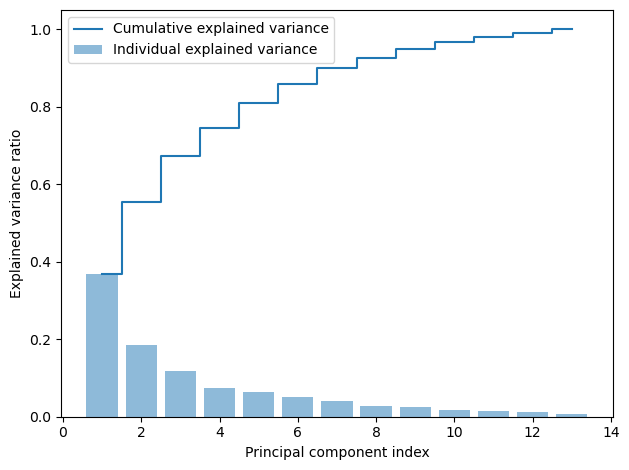

In [6]:
# 将加和的解释方差比可视化
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
# 把特征向量按特征值降序排列，从所选的特征向量构建投影矩阵，用投影矩阵把数据变换到低维子空间。把特征向量按特征值降序排列
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]   #将每个特征值的绝对值与对应的特征向量组成一个元组。

eigen_pairs.sort(key=lambda k: k[0], reverse=True)
#通过lambda k: k[0]指定按照元组中的第一个元素进行排序，reverse=True表示降序排列。

In [10]:
# 收集对应前两个最大特征值的特征向量，从数据集中捕获大约60%的方差。这里只选择两个特征向量来进行说明
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
#eigen_pairs[0]表示第一个特征值-特征向量对，eigen_pairs[0][1]表示该特征值对应的特征向量。通过[:, np.newaxis]将其转换为列向量。
#使用np.hstack()函数将这两个列向量水平拼接起来，形成投影矩阵W。
print('Matrix W:\n', w)
#每一列都是一个主成分

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [11]:
X_train_std[0].dot(w)  #X_train_std的第一条样本数据，使用投影矩阵W进行线性变换。

array([2.38299011, 0.45458499])

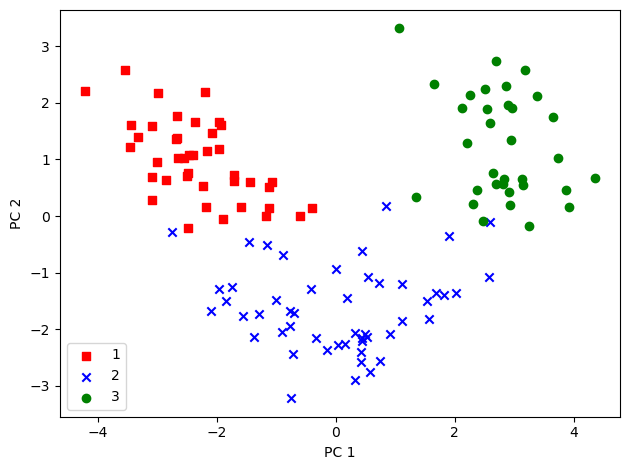

In [12]:
# 通过点积的方式将数据变成主成分
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],    #属于标签为l的样本在第一和第二个主成分上的投影。
                X_train_pca[y_train == l, 1],
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [13]:
# 通过sklearn实现PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_  #每个方差比例

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

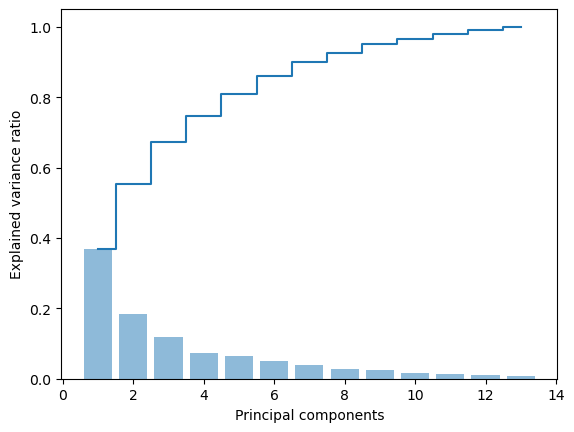

In [14]:
# 可视化解释方差比
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [15]:
# 调用pca函数，进行分析
pca = PCA(n_components=2)  #降维后的特征数为2
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

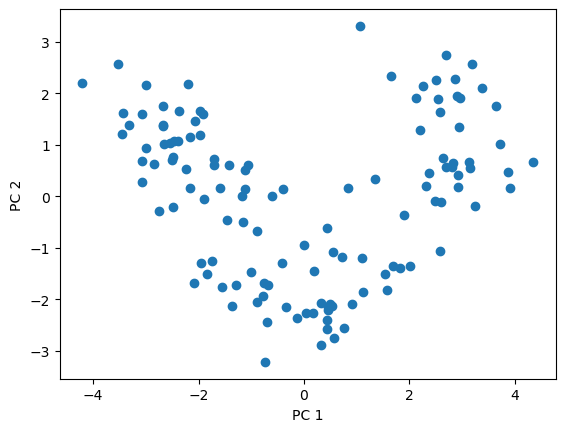

In [16]:
# 根据两个主成分画出散点图
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [17]:
#  实现决策区域的可视化
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])  #colors[:len(np.unique(y))] 的意思是根据类别数量选择对应数量的颜色。

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  #X[:, 0] 表示提取特征向量 X 的所有行（样本），并只保留第一个维度的数值。
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),  #x1_min 到 x1_max 步长为 resolution 的一维数组
                           np.arange(x2_min, x2_max, resolution))
    #np.meshgrid 函数生成一个二维的网格坐标矩阵。

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)  #将 xx1 和 xx2 的二维网格坐标矩阵展平为一维
    #利用分类器的 predict 方法对展平后的特征向量进行预测，得到对应的类别标签。对于每个网格点，都得到了一个预测值。

    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):  #表示对于每个唯一值 cl，使用变量 idx 来追踪它在数组中的索引
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

In [18]:
# 对PCA后的模型进行线性回归，完成红酒分类
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

C:\Users\WilliamGinWolf\AppData\Local\Temp\ipykernel_6884\1914469689.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


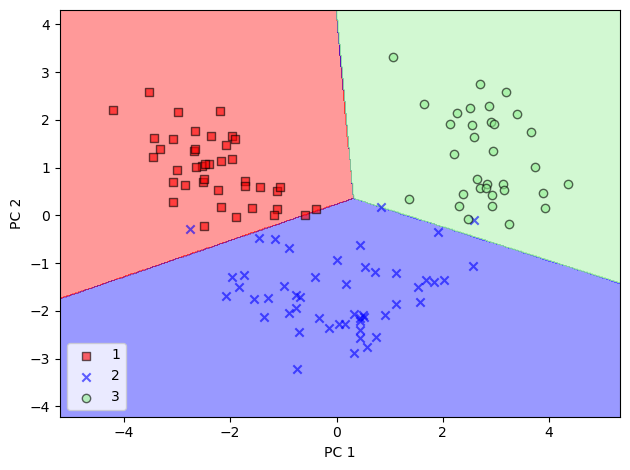

In [19]:
# 画图，将训练集分类结果可视化
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

C:\Users\WilliamGinWolf\AppData\Local\Temp\ipykernel_6884\1914469689.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


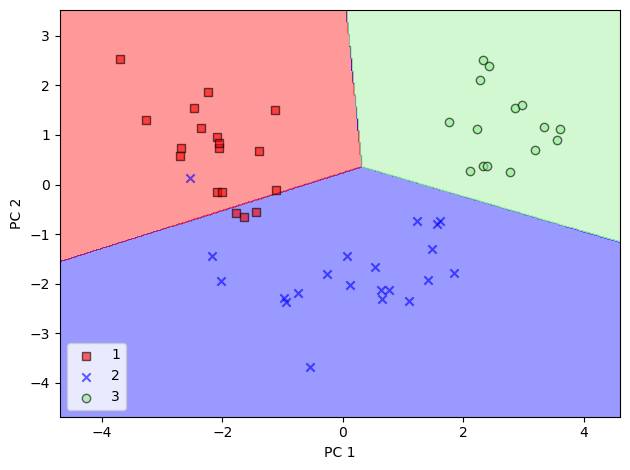

In [20]:
# 画图，将测试集分类结果可视化
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [21]:
# 通过调用 explained_variance_ratio_属性显示解释方差比
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])